In [1]:
%load_ext autoreload
%autoreload 2

In this notebook we take the data analyzed in notebook 03 and, using an interface we analyze a filtered dataset of light curves visually to determine Blazhko star candidates. We then double check the first set o Blazhko candidates to conclude the final table. Finally, we analyze that data subset in notebook 05.

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML & Astropy
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit
from astropy.coordinates import SkyCoord
import astropy.units as u


# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm
from scipy.signal import find_peaks
from array import array

In [3]:
#| code-fold: false
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from config import*
from descriptive_stats import *
from plots import *

from selection import *
from lc_analysis import *

Loading the data!


In [5]:
#| code-fold: false
# DATA
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

# Loading the light curves

After finishing the preliminary setup, it's time to load the fit data, periodograms and light curve data from the previous notebook.

In [6]:
#| code-fold: false
# LOADING LIGHT CURVE TYPES AB
RRLab = pd.read_csv('../outputs/RRLAB.csv')
RRLab.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,LC TYPE
0,29848,0.557021,0.557037,0.557029,1.000028,301.0,0.178198,3.028026,1.451336,0.185326,...,0.052598,16.195588,3.955532,15.756993,0.925157,0,0.25,0.0,0.25,1
1,50402,0.643301,0.643296,0.643298,0.999992,284.0,0.107683,0.595738,0.733869,0.106092,...,0.031558,2.097207,1.177316,16.088901,0.486372,0,0.25,0.0,0.25,1
2,62892,0.530776,0.530785,0.530781,1.000017,276.0,0.108544,1.058829,0.934727,0.114002,...,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,1
3,91437,0.674732,0.674738,0.674735,1.000009,177.0,0.040798,2.775415,1.352923,0.040888,...,0.020152,4.243845,1.580792,15.002323,0.864724,0,0.25,0.0,0.25,1
4,104455,0.997210,0.779404,0.888307,0.781584,119.0,0.000019,3.340609,1.637698,0.479566,...,0.476834,198.977212,15.997038,16.426643,0.860027,0,0.25,0.0,0.25,1


In [7]:
#| code-fold: false
# LOADING LIGHT CURVE TYPES C
RRLc = pd.read_csv('../outputs/RRLC.csv')
RRLc.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,LC TYPE
0,95250,0.313870,0.313876,0.313873,1.000019,222.0,0.162040,0.816590,0.859616,0.165801,...,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25,2
1,141414,0.335690,0.335669,0.335680,0.999937,278.0,0.119521,0.627868,0.764473,0.160812,...,0.099401,10.506837,2.802299,16.050856,0.367590,0,0.25,0.0,0.25,2
2,163933,0.339629,0.339626,0.339628,0.999991,306.0,0.064185,0.972501,0.882843,0.066518,...,0.024081,0.991889,1.002086,15.262747,0.463487,1,0.25,0.0,0.25,2
3,174389,0.332721,0.334040,0.333381,1.003964,270.0,0.201028,23.586103,5.499543,0.370497,...,0.704658,102.684694,11.918613,14.898925,0.328394,0,0.25,0.0,0.25,2
4,258499,0.401505,0.803006,0.602256,1.999989,275.0,0.123031,2.711071,1.493619,0.409720,...,1.675283,130.180418,15.710401,15.247629,0.372447,0,0.25,0.0,0.25,2


In [8]:
#| code-fold: false
# LOADING PERIODOGRAM DATA
periodograms = pickle.load(open("../outputs/periodograms_final.pkl", "rb"))

In [9]:
#| code-fold: false
# LOADING FITS DATA
FITS = np.load('../outputs/fits_FINAL_FINAL_CORRECT.npy', allow_pickle=True)

# ANALYSIS OF RRab TYPE STARS

## Preliminary statistical analysis

Before we proceed with the selection of Blazhko candidates for RRab type, it is important to do some preliminary statistical analysis of our light curve data, like plotting the period ratios and chi values, plotting the chi values against each other, etc. In this step we also decide how many points is our threshold above which we even look for potential candidates.

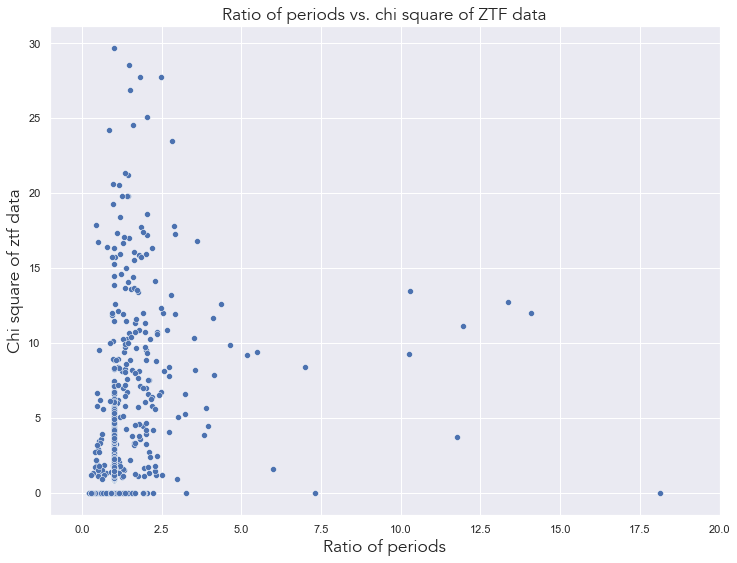

In [10]:
#| label: fig_pratio_vs_chiztf
#| fig-cap: The ratio of periods between LINEAR and ZTF light curves versus the chi square value of ZTF light curves
plt.figure(figsize=(12,9))
sns.scatterplot(RRLab, x='Pratio', y='ZPztf_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of periods vs. chi square of ZTF data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of ztf data', fontproperties=font)
plt.show()

From the first graph above we can see that most ratios of periods focus around the 1 mark, with chi quare values increasing along that line. There is another line present which indicates 0 chi square and increasing ratio of periods. The rest of the data is scattered on the graph.

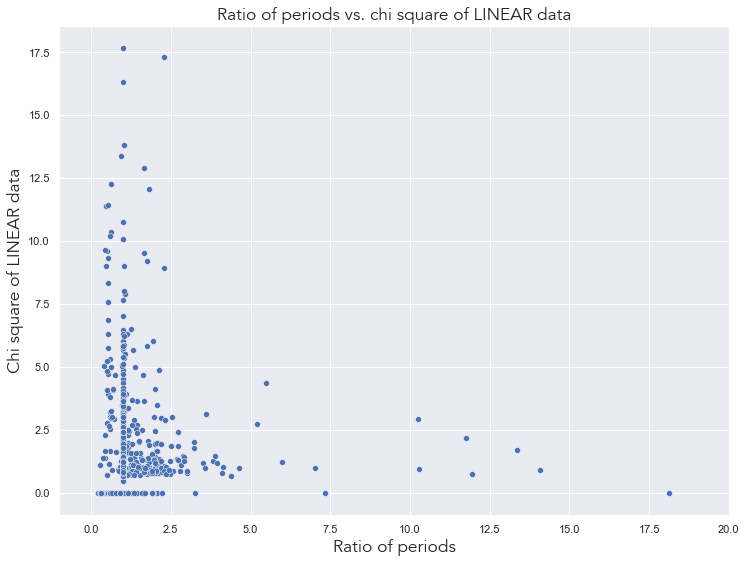

In [11]:
#| label: fig_pratio_vs_LINEARchi
#| fig-cap: The ratio of periods between LINEAR and ZTF light curves versus the chi square value of LINEAR light curves
plt.figure(figsize=(12,9))
sns.scatterplot(RRLab, x='Pratio', y='LPlin_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of periods vs. chi square of LINEAR data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of LINEAR data', fontproperties=font)
plt.show()

From the graph above, we can see the same pattern as with the ZTF data, showing that they are actually quite similar. However, more ratios of periods are scattered near the lower end of the graph (smaller chi values).

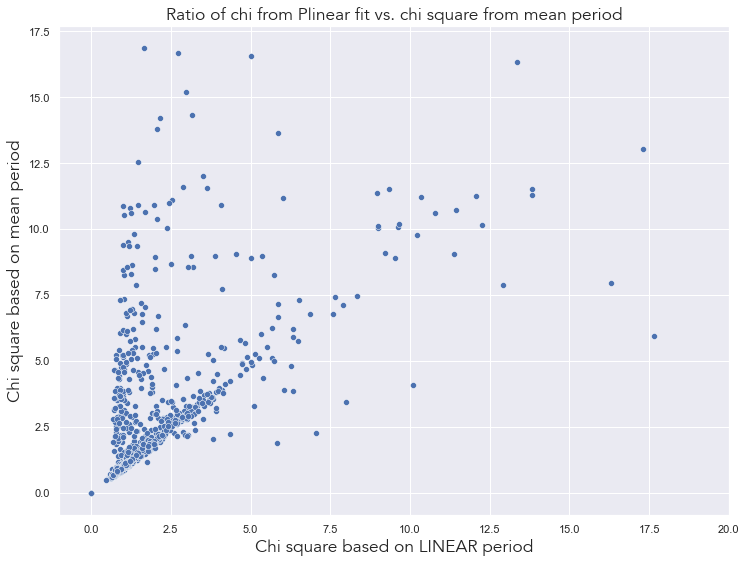

In [12]:
#| label: fig_chiL_vs_chiLmean
#| fig-cap: The chi value based on the fit from the LINEAR period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(RRLab, x='LPlin_chi2dofR', y='LPmean_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of chi from Plinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on LINEAR period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

As expected, most values fall on a diagonal line indicating that they should be the same, however a sizeable fraction isn't the same as the mean value, indicating that the `ZTF` period is pushing the mean towards a different direction than the original `LINEAR` period.

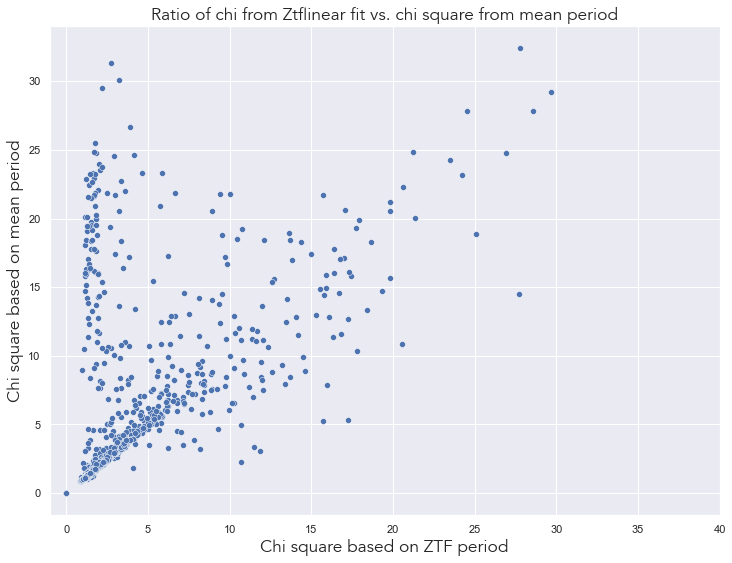

In [13]:
#| label: fig_chiZ_vs_chiZmean
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(RRLab, x='ZPztf_chi2dofR', y='ZPmean_chi2dofR')
plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

From the graph above we can also see a diagonal line indicating equality, however the data is slightly more scattered than in the `LINEAR` graph. 

### Determining the datapoint cutoff point for RRab types

After some preliminary analysis, it is important to chose a threshold for the number of data points above which we look for Blazhko stars. If there are too few points, we cannot make accurate classifications. 

First we need to calculate the differences between the chi of `LINEAR` data and the mean of chi for `LINEAR` data, and the same difference but for `ZTF` data.

In [14]:
#| code-fold: false
RRLab['Chi_diff_LINEAR'] = RRLab['LPmean_chi2dofR'] - RRLab['LPlin_chi2dofR']
RRLab['Chi_diff_ZTF'] = RRLab['ZPmean_chi2dofR'] - RRLab['ZPztf_chi2dofR']  
RRLab.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,LC TYPE,Chi_diff_LINEAR,Chi_diff_ZTF
0,29848,0.557021,0.557037,0.557029,1.000028,301.0,0.178198,3.028026,1.451336,0.185326,...,3.955532,15.756993,0.925157,0,0.25,0.0,0.25,1,0.159324,0.310458
1,50402,0.643301,0.643296,0.643298,0.999992,284.0,0.107683,0.595738,0.733869,0.106092,...,1.177316,16.088901,0.486372,0,0.25,0.0,0.25,1,0.008459,0.014946
2,62892,0.530776,0.530785,0.530781,1.000017,276.0,0.108544,1.058829,0.934727,0.114002,...,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,1,0.028766,0.151069
3,91437,0.674732,0.674738,0.674735,1.000009,177.0,0.040798,2.775415,1.352923,0.040888,...,1.580792,15.002323,0.864724,0,0.25,0.0,0.25,1,0.008148,0.024178
4,104455,0.997210,0.779404,0.888307,0.781584,119.0,0.000019,3.340609,1.637698,0.479566,...,15.997038,16.426643,0.860027,0,0.25,0.0,0.25,1,-0.106290,-0.418205


After the determination of the differences, we can plot these differences along with a hue for the number of data points, so we can see the distribution of data point sizes. 

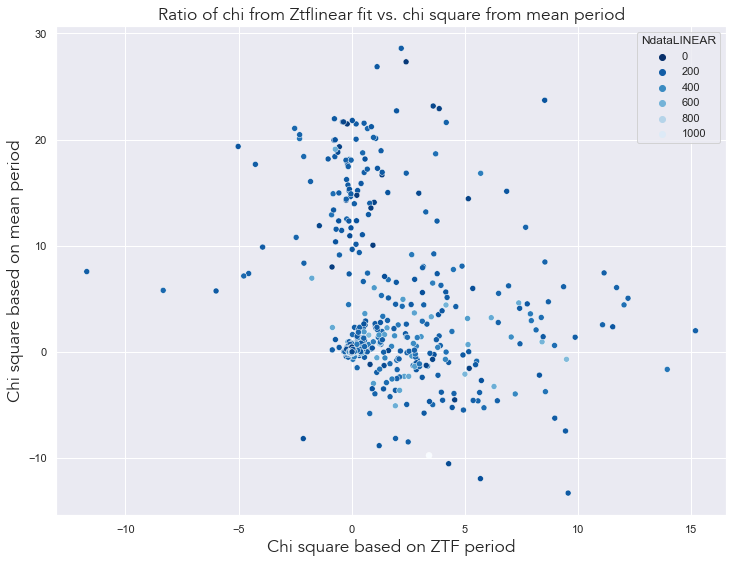

In [15]:
#| label: fig_diff_chi_NdataLinear
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(RRLab, x='Chi_diff_LINEAR', y='Chi_diff_ZTF', hue='NdataLINEAR', palette='Blues_r')
#plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

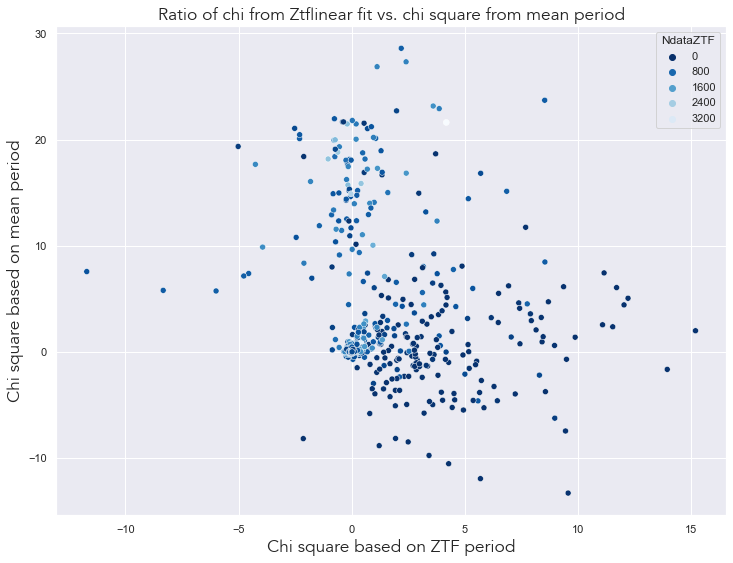

In [16]:
#| label: fig_diff_chi_NdataZtf
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(RRLab, x='Chi_diff_LINEAR', y='Chi_diff_ZTF', hue='NdataZTF', palette='Blues_r')
#plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

Based on these graphs, we can cut all light curves which have less than 40 datapoints, so that we can work with a cleaner sample and classify more accurately! Other than that, we can also notice substantial differences in the amount of data points between datasets. `LINEAR` has a more even distribtion, however with most points having a higher number of data points, while `ZTF` has a larger range, but the number of points with few data points are definitely more prominent.

In [17]:
#| code-fold: false
# CUTTING THE DATA - FILTERING FOR ROWS ABOVE 40 DATAPOINTS
RRLab = RRLab.loc[(RRLab['NdataLINEAR'] > 40) | (RRLab['NdataZTF'] > 40)]
print(RRLab.shape)

(1993, 30)


We effectively removed 151 rows of light curves from RRab type stars with too little data!

Since we are focusing on RR Lyrae stars, we know that their periods range from 3-30 hours, so all their periods should be under 3 days, but being conservative let's say 4 days. If the Lomb-Scargle periodogram somehow calculated a higher period, something is wrong with the data. Let's filter it!

In [18]:
#| code-fold: false
# CUTTING THE DATA - FILTERING FOR ROWS BELOW 3 DAYS CYCLE
RRLab = RRLab.loc[(RRLab['Plinear'] < 4) & (RRLab['Pztf'] < 4)]
print(RRLab.shape)

(1983, 30)


With this filter we effectively removed 10 stars which had unusual periods for RR Lyrae stars. Now, we can continue with further analysis.

#### Finishing up the main database

Before we begin with analysis, let's just round up our values to be easier to interpret.

In [19]:
#| code-fold: false
# ROUNDING LARGE DECIMALS
RRLab['Pratio'] = round(RRLab['Pratio'], 4)
RRLab['Plinear'] = round(RRLab['Plinear'], 6)
RRLab['Pztf'] = round(RRLab['Pztf'], 6)
RRLab['Lampl'] = round(RRLab['Lampl'], 2)
RRLab['Zampl'] = round(RRLab['Zampl'], 2)
RRLab['LPlin_chi2dofR'] = round(RRLab['LPlin_chi2dofR'], 1)
RRLab['LPmean_chi2dofR'] = round(RRLab['LPmean_chi2dofR'], 1)
RRLab['ZPztf_chi2dofR'] = round(RRLab['ZPztf_chi2dofR'], 1)
RRLab['ZPmean_chi2dofR'] = round(RRLab['ZPmean_chi2dofR'], 1)
RRLab['Ampl_diff'] = round(abs(RRLab['Lampl'] - RRLab['Zampl']), 2)

RRLab.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,LC TYPE,Chi_diff_LINEAR,Chi_diff_ZTF,Ampl_diff
0,29848,0.557021,0.557037,0.557029,1.0000,301.0,0.178198,3.028026,1.5,0.185326,...,15.756993,0.93,0,0.25,0.0,0.25,1,0.159324,0.310458,0.36
1,50402,0.643301,0.643296,0.643298,1.0000,284.0,0.107683,0.595738,0.7,0.106092,...,16.088901,0.49,0,0.25,0.0,0.25,1,0.008459,0.014946,0.00
2,62892,0.530776,0.530785,0.530781,1.0000,276.0,0.108544,1.058829,0.9,0.114002,...,15.961735,0.64,1,0.25,0.0,0.25,1,0.028766,0.151069,0.02
3,91437,0.674732,0.674738,0.674735,1.0000,177.0,0.040798,2.775415,1.4,0.040888,...,15.002323,0.86,0,0.25,0.0,0.25,1,0.008148,0.024178,0.01
4,104455,0.997210,0.779404,0.888307,0.7816,119.0,0.000019,3.340609,1.6,0.479566,...,16.426643,0.86,0,0.25,0.0,0.25,1,-0.106290,-0.418205,11782.10


# Filtering the data for Blazhko candidates

### Creating a dataset with all possible Blazhko candidates

The next step is to create a dataset where at least one of the many criteria for Blazhko stars is met. 

The parameters:

1. <span style="color:CadetBlue">Ratio of Periods</span>: must be below 0.99 and above 1.01 (when rounded to 2 decimals).

2. <span style="color:CadetBlue">Chi square</span>: has to be above 3 for a significant change for the Blazhko effect.

3. <span style="color:CadetBlue">Indicator from periodogram</span>: `Zindicator` and `Lindicator` should be 1 (however in other situations one or the either can be 1).

4. <span style="color:CadetBlue">Amplitude</span>: if the amplitude change is greater than 0.01.

In [20]:
#| code-fold: false
# PARAMETER VALUES
chi = 3.0
pratio_less = 0.99
pratio_more = 1.01
ampl = 0.01

## Determining Blazhko candidates for RRab type stars

### 

In [21]:
#| code-fold: false
# SELECTING THE ROWS
RRAB_filter = RRLab.loc[((RRLab['Lindicator'] != 0) | 
                                             (RRLab['Zindicator'] != 0.0))]
RRAB_filter = RRAB_filter.loc[((RRLab['LPlin_chi2dofR'] > chi) & 
                                             (RRLab['ZPztf_chi2dofR'] > chi)) | 
                                             ((RRLab['Pratio'] > pratio_less) | 
                                             (RRLab['Pratio'] < pratio_more)) |
                                             (RRLab['Ampl_diff'] > ampl)]
print(f'This dataset has {RRAB_filter.shape[0]} rows and {RRAB_filter.shape[1]} columns.')
RRAB_filter.head()

This dataset has 516 rows and 31 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,LC TYPE,Chi_diff_LINEAR,Chi_diff_ZTF,Ampl_diff
2,62892,0.530776,0.530785,0.530781,1.0,276.0,0.108544,1.058829,0.9,0.114002,...,15.961735,0.64,1,0.25,0.0,0.25,1,0.028766,0.151069,0.02
6,136668,0.532922,0.532929,0.532926,1.0,310.0,0.122892,1.639568,1.1,0.121226,...,16.107864,0.78,1,0.25,0.0,0.25,1,-0.038400,0.168693,0.04
7,142794,0.470787,0.470804,0.470796,1.0,270.0,0.095738,1.814911,1.0,0.100813,...,15.745773,0.82,1,0.25,0.0,0.25,1,0.048320,-0.063895,0.10
14,303860,0.492145,0.492164,0.492155,1.0,280.0,0.090758,3.474911,1.4,0.100403,...,15.599545,0.77,0,0.25,1.0,0.25,1,0.020522,0.403089,0.15
16,355767,0.521368,0.521363,0.521366,1.0,180.0,0.103821,0.987307,0.9,0.109992,...,16.344715,0.84,0,0.25,1.0,0.25,1,0.050223,-0.035526,0.00


So, in total 519 stars exhibit one of these rules!

## Building an interface for distinguishing Blazhko stars

The interface is going to loop through every light curve in our filtered dataset, and plot 6 graphs of the data, the `LINEAR` fits, `ZTF` fits and the periodograms. Above, the main and important information is going to be printed about each light curve, or the criteria we specified above. Below, there are going to be 2 buttons: the `CONTINUE` and `KEEP` button. The `CONTINUE` button signals the for loop to continue running, essentially discarding the light curve as not a Blazhko star. The `KEEP` button however, takes the current row of the dataset and concatenates it with our `BLAZHKO_STARS_AB` DataFrame. After saving our light curve, we click `CONTINUE` again to continue the for loop. 

### RRab Stars

In [22]:
#| code-fold: false
# DEFINING CONSTANTS AND CONFIGURATION FOR INTERFACE
# ----------------------------------------------------
#dataset = lightcurve_criterium
RRAB_filter = RRAB_filter.reset_index()
dataset = RRAB_filter

test = 1
#test = dataset.shape[0]
ids = dataset['LINEAR id'].to_numpy()

# DATAFRAME for storing Blazhko candidates
blazhko_list_ab = pd.DataFrame(())

In [23]:
#| code-fold: false
current_i = None  # Initialize current_i

def plot_light_curves(test):
    '''
    For loop for plotting all desired light curves.

    test(int) = number of times to go through the for loop
    '''
    global current_i # set up current_i as a global variable
    for i in range(test): # define the main for loop
        current_i = i
        LID = ids[i]
        blazhko_analysis(RRAB_filter, Lid=LID, order=i, PD=periodograms, fits=FITS, name=str(LID)) # plot all necessary plots
        yield # wait for button click to continue

gen = plot_light_curves(test) # setup object for function

button_keeping = widgets.Button(description='Keep') # keep button
button_continue = widgets.Button(description='Continue') # continue button

# set up output for plots (making them visible)
output_plot = widgets.Output()

# define what happens when continue is clicked
def on_continue_click(b):
    '''
    A function which defines what happens when we click the Continue button:
    the counter updates and we move on to the next example.
    '''
    global current_i # remember what current_i is since it is a global variable and can be changed and updated
    with output_plot: # clear previous plot
        clear_output(wait=True)
        try:
            next(gen) # go to next i value (plot next plot.)
        except StopIteration: # when loop is finished
            print("No more plots.")
            button_continue.disabled = True # disable button

# define what happens when keep is clicked
def on_keep_click(b):
    '''
    A function which defines what happens when we click the Keep button: the data is saved into
    an external table.
    '''
    global blazhko_list_ab # make this table global so it can be updated and changed
    row = pd.DataFrame(dataset.iloc[[int(current_i)]]) # find the row for that specific i (current_i)
    blazhko_list_ab = pd.concat([blazhko_list_ab, row], ignore_index=True, axis=0) # concatenate it with the BLAZHKO_STARS dataframe

# define that clicking keep corresponds to the function on_keep_click
button_keeping.on_click(on_keep_click)
# define that clicking continue corresponds to the function on_continue_click
button_continue.on_click(on_continue_click)

# display everything organized as plot - keep - continue
display(output_plot, button_keeping, button_continue)

on_continue_click(None) # begin the loop

Output()

Button(description='Keep', style=ButtonStyle())

Button(description='Continue', style=ButtonStyle())

In [32]:
print(blazhko_list_ab.shape)
print(current_i)

(0, 0)
0


#### Saving the dataset!

In [31]:
#| code-fold: false
name = 'FINAL'
blazhko_list_ab = blazhko_list_ab.drop_duplicates(subset=['LINEAR id'], keep='first')
print(blazhko_list_ab.shape)
blazhko_list_ab.to_csv("../outputs/BLAZHKO_LIST_ab_"+name+".csv", index=False)

(109, 30)


So, it turns out that during our analysis there have been 39 duplicates! This might be due to clicking the `Continue` button twice by accident or during the joining process, when the second table was created the light curves started a bit earlier (although this constitutes 1-2 stars).

# Analyzing RRc type stars

## Preliminary statistical analysis

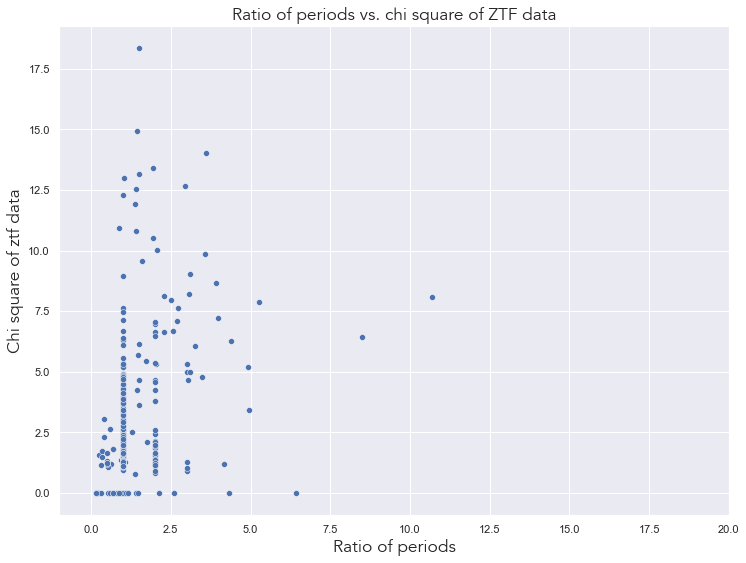

In [22]:
#| label: fig_pratio_vs_chiztf_c
#| fig-cap: The ratio of periods between LINEAR and ZTF light curves versus the chi square value of ZTF light curves
plt.figure(figsize=(12,9))
sns.scatterplot(RRLc, x='Pratio', y='ZPztf_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of periods vs. chi square of ZTF data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of ztf data', fontproperties=font)
plt.show()

As with RRab type stars, the graph looks almost exactly the same, however it has a secondary line at around 2 for ratio of periods which continues straight up with chi. 

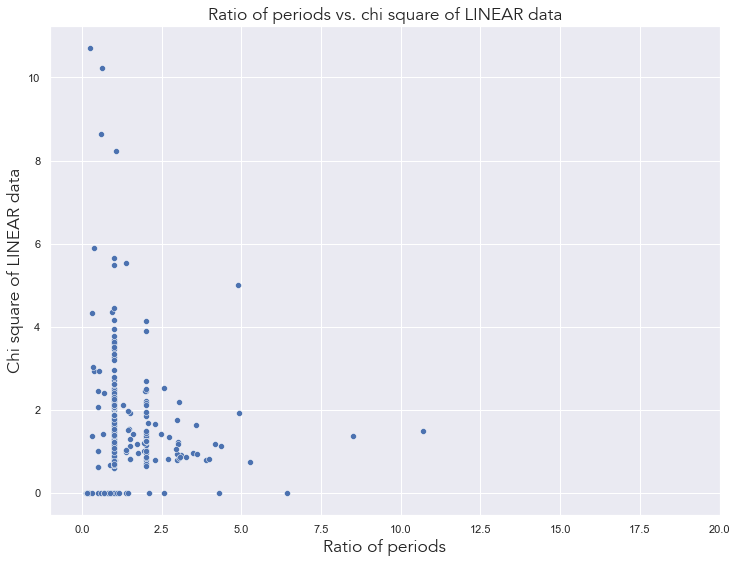

In [23]:
#| label: fig_pratio_vs_LINEARchi_c
#| fig-cap: The ratio of periods between LINEAR and ZTF light curves versus the chi square value of LINEAR light curves
plt.figure(figsize=(12,9))
sns.scatterplot(RRLc, x='Pratio', y='LPlin_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of periods vs. chi square of LINEAR data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of LINEAR data', fontproperties=font)
plt.show()

We can see that the graph is almost exactly the same for `LINEAR` as well as `ZTF` data for RRc type stars.

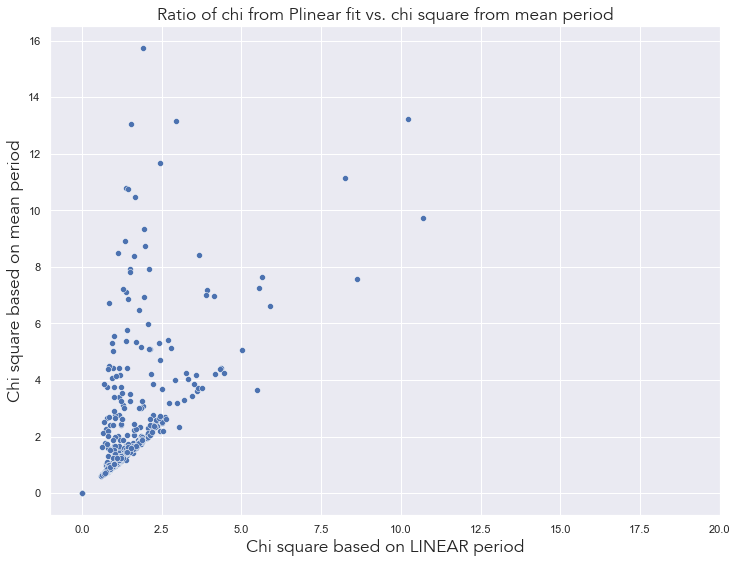

In [24]:
#| label: fig_chiL_vs_chiLmean_c
#| fig-cap: The chi value based on the fit from the LINEAR period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(RRLc, x='LPlin_chi2dofR', y='LPmean_chi2dofR')
plt.xlim(-1, 20)
plt.title('Ratio of chi from Plinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on LINEAR period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

We can see a similar relationship between RRc and RRab, with a main line going directly linearly, and then we have a smaller group of outliers which are very interesting for analysis!

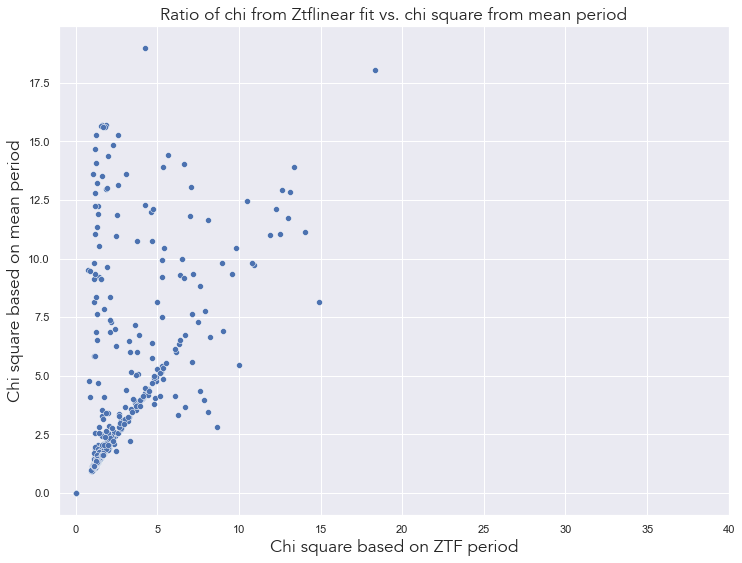

In [25]:
#| label: fig_chiZ_vs_chiZmean_c
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(RRLc, x='ZPztf_chi2dofR', y='ZPmean_chi2dofR')
plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

Same as with `LINEAR` data, however a tad more scattered. There appear to be less clear outliers, but the scatterdness also implies that the data might hold something interesting.

### Determining the cutoff point

We repeat the same steps as with RRab type stars.

In [26]:
#| code-fold: false
RRLc['Chi_diff_LINEAR'] = RRLc['LPmean_chi2dofR'] - RRLc['LPlin_chi2dofR']
RRLc['Chi_diff_ZTF'] = RRLc['ZPmean_chi2dofR'] - RRLc['ZPztf_chi2dofR']  
RRLc.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,LC TYPE,Chi_diff_LINEAR,Chi_diff_ZTF
0,95250,0.313870,0.313876,0.313873,1.000019,222.0,0.162040,0.816590,0.859616,0.165801,...,1.515406,16.680144,0.461509,1,0.25,0.0,0.25,2,0.005548,0.173992
1,141414,0.335690,0.335669,0.335680,0.999937,278.0,0.119521,0.627868,0.764473,0.160812,...,2.802299,16.050856,0.367590,0,0.25,0.0,0.25,2,0.251946,1.344038
2,163933,0.339629,0.339626,0.339628,0.999991,306.0,0.064185,0.972501,0.882843,0.066518,...,1.002086,15.262747,0.463487,1,0.25,0.0,0.25,2,0.039070,-0.048520
3,174389,0.332721,0.334040,0.333381,1.003964,270.0,0.201028,23.586103,5.499543,0.370497,...,11.918613,14.898925,0.328394,0,0.25,0.0,0.25,2,-1.867197,10.513016
4,258499,0.401505,0.803006,0.602256,1.999989,275.0,0.123031,2.711071,1.493619,0.409720,...,15.710401,15.247629,0.372447,0,0.25,0.0,0.25,2,1.778763,14.082531


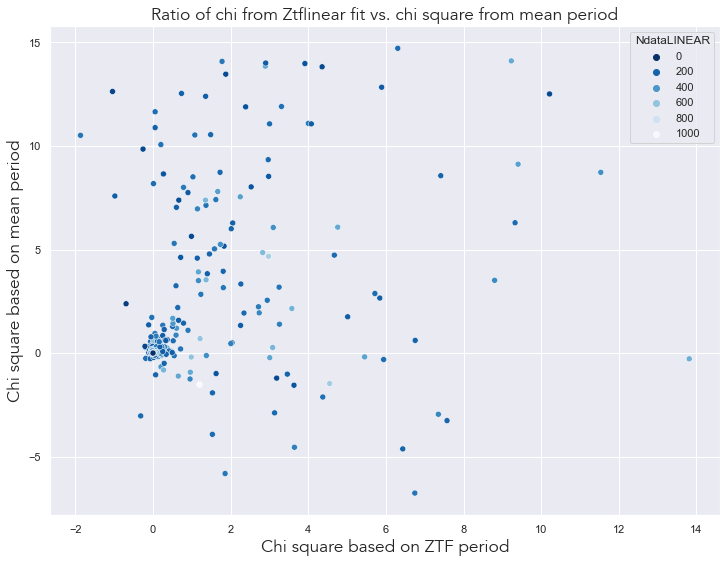

In [27]:
#| label: fig_diff_chi_NdataLinear_c
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(RRLc, x='Chi_diff_LINEAR', y='Chi_diff_ZTF', hue='NdataLINEAR', palette='Blues_r')
#plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

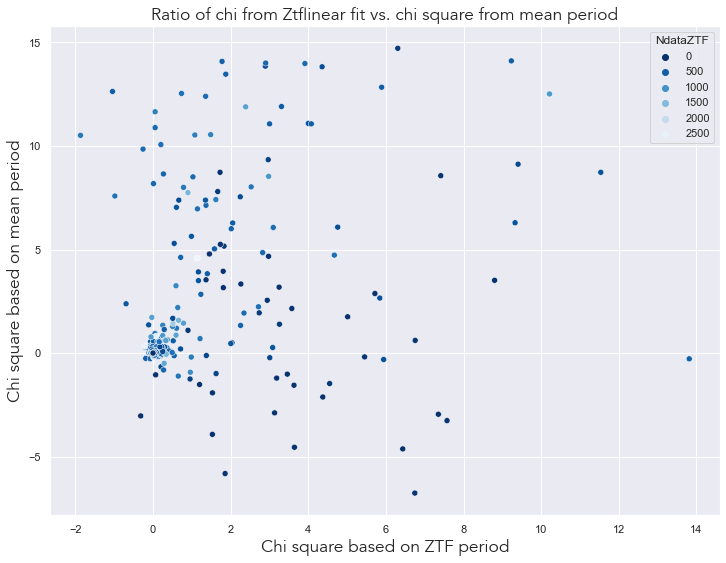

In [28]:
#| label: fig_diff_chi_NdataZtf
#| fig-cap: The chi value based on the fit from the ZTF period versus the chi value based on the fit from the mean period
plt.figure(figsize=(12,9))
sns.scatterplot(RRLc, x='Chi_diff_LINEAR', y='Chi_diff_ZTF', hue='NdataZTF', palette='Blues_r')
#plt.xlim(-1, 40)
plt.title('Ratio of chi from Ztflinear fit vs. chi square from mean period', fontproperties=font)
plt.xlabel('Chi square based on ZTF period', fontproperties=font)
plt.ylabel('Chi square based on mean period', fontproperties=font)
plt.show()

We can see a similar situation as with RRab stars: `LINEAR` has overall less data points than `ZTF`, but overall each point on this graph has many data points, so we can again make the cutoff point 40 data points.

In [29]:
#| code-fold: false
# CUTTING THE DATA - FILTERING FOR ROWS ABOVE 40 DATAPOINTS
RRLc = RRLc.loc[(RRLc['NdataLINEAR'] > 40) | (RRLc['NdataZTF'] > 40)]
print(RRLc.shape)

(523, 30)


We removed 43 light curves with too little data points!

### Finishing up main database

In [30]:
#| code-fold: false
# ROUNDING LARGE DECIMALS
RRLc['Pratio'] = round(RRLc['Pratio'], 4)
RRLc['Plinear'] = round(RRLc['Plinear'], 6)
RRLc['Pztf'] = round(RRLc['Pztf'], 6)
RRLc['Lampl'] = round(RRLc['Lampl'], 2)
RRLc['Zampl'] = round(RRLc['Zampl'], 2)
RRLc['LPlin_chi2dofR'] = round(RRLc['LPlin_chi2dofR'], 1)
RRLc['LPmean_chi2dofR'] = round(RRLc['LPmean_chi2dofR'], 1)
RRLc['ZPztf_chi2dofR'] = round(RRLc['ZPztf_chi2dofR'], 1)
RRLc['ZPmean_chi2dofR'] = round(RRLc['ZPmean_chi2dofR'], 1)
RRLc['Ampl_diff'] = round(abs(RRLc['Lampl'] - RRLc['Zampl']), 2)

RRLc.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,LC TYPE,Chi_diff_LINEAR,Chi_diff_ZTF,Ampl_diff
0,95250,0.313870,0.313876,0.313873,1.0000,222.0,0.162040,0.816590,0.9,0.165801,...,16.680144,0.46,1,0.25,0.0,0.25,2,0.005548,0.173992,0.02
1,141414,0.335690,0.335669,0.335680,0.9999,278.0,0.119521,0.627868,0.8,0.160812,...,16.050856,0.37,0,0.25,0.0,0.25,2,0.251946,1.344038,0.04
2,163933,0.339629,0.339626,0.339628,1.0000,306.0,0.064185,0.972501,0.9,0.066518,...,15.262747,0.46,1,0.25,0.0,0.25,2,0.039070,-0.048520,0.01
3,174389,0.332721,0.334040,0.333381,1.0040,270.0,0.201028,23.586103,5.5,0.370497,...,14.898925,0.33,0,0.25,0.0,0.25,2,-1.867197,10.513016,0.29
4,258499,0.401505,0.803006,0.602256,2.0000,275.0,0.123031,2.711071,1.5,0.409720,...,15.247629,0.37,0,0.25,0.0,0.25,2,1.778763,14.082531,0.03


## Selecting stars to be used in analysis

In [33]:
#| code-fold: false
# PARAMETER VALUES
chi = 3.0
pratio_less = 0.99
pratio_more = 1.01
ampl = 0.01

In [34]:
#| code-fold: false
# SELECTING THE ROWS
RRC_filter = RRLc.loc[((RRLc['Lindicator'] != 0) | 
                                             (RRLc['Zindicator'] != 0.0))]
RRC_filter = RRC_filter.loc[((RRLc['LPlin_chi2dofR'] > chi) & 
                                             (RRLc['ZPztf_chi2dofR'] > chi)) | 
                                             ((RRLc['Pratio'] > pratio_less) | 
                                             (RRLc['Pratio'] < pratio_more)) |
                                             (RRLc['Ampl_diff'] > ampl)]
print(f'This dataset has {RRC_filter.shape[0]} rows and {RRC_filter.shape[1]} columns.')
RRC_filter.head()

This dataset has 287 rows and 31 columns.


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,LC TYPE,Chi_diff_LINEAR,Chi_diff_ZTF,Ampl_diff
0,95250,0.313870,0.313876,0.313873,1.0000,222.0,0.162040,0.816590,0.9,0.165801,...,16.680144,0.46,1,0.25,0.0,0.25,2,0.005548,0.173992,0.02
2,163933,0.339629,0.339626,0.339628,1.0000,306.0,0.064185,0.972501,0.9,0.066518,...,15.262747,0.46,1,0.25,0.0,0.25,2,0.039070,-0.048520,0.01
5,516954,0.297570,0.297569,0.297569,1.0000,243.0,0.184932,5.571245,2.4,0.183362,...,15.634764,0.42,1,0.25,0.0,0.25,2,0.004314,-0.016976,0.10
6,523832,0.372376,0.372384,0.372380,1.0000,251.0,0.101045,1.778302,1.2,0.103623,...,15.358163,0.43,1,0.25,0.0,0.25,2,0.072532,-0.123884,0.01
8,734545,0.289482,0.600607,0.445044,2.0748,305.0,0.141460,3.268840,1.7,1.007203,...,15.115288,0.37,1,0.25,0.0,0.25,2,3.643657,-4.548143,0.08


## Search for the Blazhko effect in RRc stars

In [35]:
#| code-fold: false
# DEFINING CONSTANTS AND CONFIGURATION FOR INTERFACE
# ----------------------------------------------------

test = RRLc.shape[0]
ids = RRLc['LINEAR id'].to_numpy()
chi_L = RRLc['LPlin_chi2dofR'].to_numpy()
chi_Z = RRLc['LPlin_chi2dofR'].to_numpy()
pratio = RRLc['Pratio'].to_numpy()
L, Z = RRLc['Lindicator'].to_numpy(), RRLc['Zindicator'].to_numpy()
ampl = RRLc['Ampl_diff'].to_numpy()

# DATAFRAME for storing Blazhko candidates
blazhko_list_c = pd.DataFrame(())

In [37]:
#| code-fold: false
current_i = None  # Initialize current_i

def plot_light_curves(test):
    '''
    For loop for plotting all desired light curves.

    test(int) = number of times to go through the for loop
    '''
    global current_i # set up current_i as a global variable
    for i in range(test): # define the main for loop
        current_i = i
        LID = ids[i]
        blazhko_analysis(RRLc, Lid=LID, order=i, PD=periodograms, fits=FITS, name=str(LID)) # plot all necessary plots
        yield # wait for button click to continue

gen = plot_light_curves(test) # setup object for function

button_keeping = widgets.Button(description='Keep') # keep button
button_continue = widgets.Button(description='Continue') # continue button

# set up output for plots (making them visible)
output_plot = widgets.Output()

# define what happens when continue is clicked
def on_continue_click(b):
    '''
    A function which defines what happens when we click the Continue button:
    the counter updates and we move on to the next example.
    '''
    global current_i # remember what current_i is since it is a global variable and can be changed and updated
    with output_plot: # clear previous plot
        clear_output(wait=True)
        try:
            next(gen) # go to next i value (plot next plot.)
        except StopIteration: # when loop is finished
            print("No more plots.")
            button_continue.disabled = True # disable button

# define what happens when keep is clicked
def on_keep_click(b):
    '''
    A function which defines what happens when we click the Keep button: the data is saved into
    an external table.
    '''
    global blazhko_list_c # make this table global so it can be updated and changed
    row = pd.DataFrame(dataset.iloc[[int(current_i)]]) # find the row for that specific i (current_i)
    blazhko_list_c = pd.concat([blazhko_list_c, row], ignore_index=True, axis=0) # concatenate it with the BLAZHKO_STARS dataframe

# define that clicking keep corresponds to the function on_keep_click
button_keeping.on_click(on_keep_click)
# define that clicking continue corresponds to the function on_continue_click
button_continue.on_click(on_continue_click)

# display everything organized as plot - keep - continue
display(output_plot, button_keeping, button_continue)

on_continue_click(None) # begin the loop

Output()

Button(description='Keep', style=ButtonStyle())

Button(description='Continue', style=ButtonStyle())

# Analyzing the RRab Blazhko candidates

In [26]:
blazhko_list_ab = pd.read_csv('../outputs/BLAZHKO_LIST_FINAL.csv')
blazhko_list_ab.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit,Chi_diff_LINEAR,Chi_diff_ZTF,Ampl_diff
0,62892,0.530776,0.530785,0.530781,1.0,276.0,0.108544,1.058829,0.934727,0.114002,...,3.288505,15.961735,0.641651,1,0.25,0.0,0.25,0.028766,0.151069,0.017
1,163933,0.339629,0.339626,0.339628,1.0,306.0,0.064185,0.972501,0.882843,0.066518,...,1.002086,15.262747,0.463487,1,0.25,0.0,0.25,0.039070,-0.048520,0.014
2,523832,0.372376,0.372384,0.372380,1.0,251.0,0.101045,1.778302,1.177467,0.103623,...,1.131261,15.358163,0.434539,1,0.25,0.0,0.25,0.072532,-0.123884,0.014
3,813450,0.589389,0.589390,0.589389,1.0,221.0,0.130989,1.978570,1.324242,0.131192,...,0.994425,15.902661,0.652062,0,0.25,1.0,0.25,0.009706,-0.011864,0.048
4,966279,0.517279,0.517270,0.517274,1.0,330.0,0.089580,6.080173,1.464833,0.093553,...,2.628205,15.540073,0.819651,1,0.25,0.0,0.25,-0.016399,-0.107766,0.103


In [27]:
blazhko_list_ab.shape

(109, 30)

# Plotting the RRab and RRc stars on the celestial sphere

In [37]:
#| code-fold: false
# DETERMINING THE RECTASCENSION AND DECLINATION COORDS
ids_ab = blazhko_list_ab['LINEAR id'].to_numpy()
rec_ab = []
dec_ab = []

for i in ids_ab: # for every id in our dataset
    # look for the index of the current id in the total dataset of stellar attributes
    for j in range(len(data.targets)): 
        if data.targets[j][0] == i:
            coords = data.targets[j] # select the coordinates for this particular id
            break
    ra, dec = coords[3], coords[4] # select rectascension and declination
    rec_ab.append(ra*u.deg) # convert ra into degrees for later conversion
    dec_ab.append(dec*u.deg) # convert dec into degrees for later conversion

print(len(rec_ab), len(dec_ab))

109 109


In [54]:
#| code-fold: false
# CONVERTING THE COORDINATES INTO GALACTIC COORDS

l_ab = []
b_ab = []

for k in range(len(rec_ab)): # for every star in our ab dataset
    # selection of ra and dec coords
    ra = rec_ab[k]
    dec = dec_ab[k]

    # converting them into galactic coordinates
    c = SkyCoord(ra=ra, dec=dec, frame='icrs')
    l = round(c.galactic.l.degree, 3)
    b = round(c.galactic.b.degree, 3)

    # convert the coordinates into a range from -180º to 180º for our projection 
    l_rad = np.radians(l)
    l_rad = np.mod(l_rad + np.pi, 2.0 * np.pi) - np.pi
    b_rad = np.radians(b)

    l_ab.append(l_rad)
    b_ab.append(b_rad)
print(len(l_ab), len(b_ab))

109 109


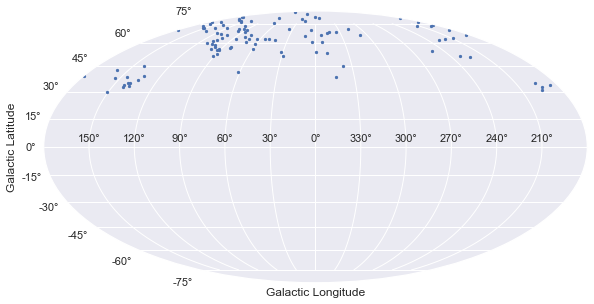

In [55]:
#| code-fold: false
# PLOTTING THE STARS

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(l_ab, b_ab, s=5)
ax.grid(True)
ax.set_xticks(np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]))
ax.set_xticklabels(['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'])
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
plt.show()